In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os, sys
from scipy import interpolate
import cartopy.crs as ccrs
import matplotlib.colors as colors
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.collections import LineCollection
from matplotlib import cm
from datetime import datetime
import pickle, warnings

In [2]:
sys.path.append(os.path.abspath("/groups/sylvia/UTLS-profiles/traj/"))
sys.path.append(os.path.abspath("/groups/sylvia/UTLS-profiles/utilities/"))
#from traj_psd_obs import traj_psd
from plotting_utilities import *
#from densityPlot import *
from flighttrack import *
#from thermodynamic_functions import *

farbe = sim_colors()

# Figure 1: Trajectories over domain + synthetic flight track idea

In [3]:
# Read in a full 51-hour long trajectory file. Initialize empty arrays for altitude, latitude, longitude.
basedir = '/xdisk/sylvia/traj_output/traj_ICON_0V2M0A0R/'
pi = 3.141592653589793238
os.environ["CARTOPY_USER_BACKGROUNDS"] = "/xdisk/sylvia/TROPIC/natural_earth/"

# Below the file is just a sample one.
#fi_name = basedir + 'traj_tst00000450_p011.nc'
fi_name = '/xdisk/sylvia/traj_tst00000450_p011.nc'
timesteps = 7651
numtraj = xr.open_dataset(fi_name).dims['id']

traj_alt = np.zeros((timesteps,numtraj))
traj_lat = np.zeros((timesteps,numtraj))
traj_lon = np.zeros((timesteps,numtraj))

FileNotFoundError: [Errno 2] No such file or directory: b'/xdisk/sylvia/traj_tst00000450_p011.nc'

In [12]:
# Read in the altitude, longitude, latitude values
fi = xr.open_dataset(fi_name)
alt = fi.alt.values
lon = fi.lon.values
lat = fi.lat.values
t = fi.t.values
rtime = fi.rtime.values

# Find indices where the matrix != 0.
xs, ys = np.where(alt != 0)
# Extract the square with extreme limits.
# In limited testing, this seems always to generate [=] (88,5308)
alt = alt[:max(xs)+1,:max(ys)+1]
lon = lon[:max(xs)+1,:max(ys)+1]
lat = lat[:max(xs)+1,:max(ys)+1]
rtime = rtime[:max(xs)+1]

In [15]:
# Store the trimmed matrices.
temp1 = alt/1000.
temp2 = rad2deg(lat)
temp3 = rad2deg(lon)

# Mask the negative altitudes and fill values (-999.) for latitudes and longitudes.
traj_alt = np.where((temp1 > 0), temp1, np.nan)
traj_lat = np.where((temp2 >= -90.), temp2, np.nan)
traj_lon = np.where((temp3 >= -180.), temp3, np.nan)

In [22]:
# Flight 7 track
basedir = '/xdisk/sylvia/tropic_vis/'
scfi = basedir + 'obs/stratoclim2017.geophysika.0808_1.master.ci_eval.nc'
sc_data = xr.open_dataset(scfi)
lat_sc = sc_data['BEST:LAT'].values
lon_sc = sc_data['BEST:LON'].values
t_sc = sc_data['time'].values
i_sc = np.argwhere((~np.isnan(lat_sc)) & (~np.isnan(lon_sc)) & (lat_sc > 0) & (lon_sc > 0))

/home/u18/sylvia/.conda/envs/ncplot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


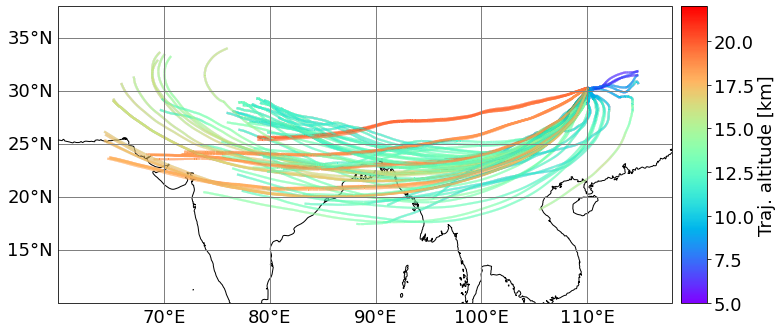

In [26]:
fs = 18
fig = plt.figure(figsize=(12,12))
gs = fig.add_gridspec(2,1)
ax0 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())

gl = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size':fs}
gl.ylabel_style = {'size':fs}

ax0.set_xlabel(r'Latitude [$^{\circ}$N]',fontsize=fs)
ax0.set_ylabel(r'Longitude [$^{\circ}$E]',fontsize=fs)

ax0.set_extent([60, 118, 10, 38],crs=ccrs.PlateCarree()) # large domain
ax0.coastlines()
#ax0.background_img(name='BM',resolution='high')
norm = plt.Normalize(5,22)

# How many trajectories to plot?
n = 80
for i in np.arange(n):
    # Create a set of line segments to color individually. Points in N x 1 x 2 array.
    points = np.array([traj_lon[:,i],traj_lat[:,i]]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments,cmap='rainbow',norm=norm)
    lc.set_array(traj_alt[:,i])
    lc.set_linewidth(2)
    line = ax0.add_collection(lc)

# Pulling from https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/multicolored_line.html
# Create a set of line segments so that we can color them individually
#points = np.array([lon_sc[i_sc[:,0]], lat_sc[i_sc[:,0]]]).T.reshape(-1,1,2)
#segments = np.concatenate([points[:-1], points[1:]], axis=1)

sm = plt.cm.ScalarMappable(cmap='rainbow',norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])

def resize_colorbar(event):
    plt.draw()
    posn = ax0.get_position()
    cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                          0.03, posn.height])
    
fig.canvas.mpl_connect('resize_event', resize_colorbar)
c = plt.colorbar(sm, cax=cbar_ax)
c.set_label('Traj. altitude [km]',fontsize=fs)
c.ax.tick_params(labelsize=fs)
resize_colorbar(None)

# Convert the times from np.datetime64 to float
#t_sc1 = t_sc[i_sc[:,0]]
#t_sc_f = t_sc1.astype("float")/1000000000.0
#t_sc_f = t_sc_f - np.nanmin(t_sc_f)
#norm = plt.Normalize(t_sc_f.min(),t_sc_f.max())
#lc = LineCollection(segments, cmap=cm.autumn, norm=norm)
#lc.set_array(t_sc_f)
#lc.set_linewidth(4)
#ax0.add_collection(lc)   
#ax0.text(0.02 ,1.05, '(a)', weight='bold', fontsize=fs+4, transform=ax0.transAxes)

#ax1 = fig.add_subplot(gs[1,0])
#img = plt.imread( '/xdisk/sylvia/tropic_vis/output/syn-flight-track-schematic.jpg' )
#plt.imshow( img )
#plt.axis('off')
#ax1.text(0.02 ,1.05, '(b)', weight='bold', fontsize=fs+4, transform=ax1.transAxes)

#fig.savefig('/xdisk/sylvia/tropic_vis/output/trajectories.png', bbox_inches='tight')
fig.savefig('/home/u18/sylvia/Proposals/trajectory-sample.png', bbox_inches='tight')
plt.show()

# Figure 2: Updraft velocity PDF + gravity wave spectrum

In [58]:
# Load the observational w values and evaluate their histogram.
basedir = '/xdisk/sylvia/tropic_vis/obs/POSIDON/'
posidon_winds = pd.read_csv(basedir + 'posidon_vertical_wind2.dat',sep='\s+')

# Filter out the w values only for z > 15 km
posidon_winds = posidon_winds[(posidon_winds['z'] >= 15)]
w_obs = posidon_winds['w']

# Calculate the normalized / relative frequency of these w values
wgts = np.ones_like(w_obs)/len(w_obs)
h_POSIDON, bin_edges = np.histogram(w_obs, bins=np.linspace(-3,3,100), weights=wgts) # density=True)
print('POSIDON campaign (mean, std) w: ' + str(np.nanmean(w_obs)) + ' ' + str(np.std(w_obs)))

basedir = '/xdisk/sylvia/tropic_vis/obs/ATTREX/'
attrex_winds = pd.read_csv(basedir + 'attrex3_vertical_wind2.dat',sep='\s+')

# Filter out the w values only for z > 15 km
attrex_winds = attrex_winds[(attrex_winds['z'] >= 15)]
w_obs = attrex_winds['w']

# Calculate the normalized / relative frequency of these w values
wgts = np.ones_like(w_obs)/len(w_obs)
h_ATTREX, bin_edges = np.histogram(w_obs, bins=np.linspace(-3,3,100), weights=wgts) # density=True)
print('ATTREX campaign (mean, std) w: ' + str(np.nanmean(w_obs)) + ' ' + str(np.std(w_obs)))

POSIDON campaign (mean, std) w: 0.08748738843285492 0.5858340614769502
ATTREX campaign (mean, std) w: -0.06651030636098923 0.23498594232830203


In [59]:
# Fixed set of frequencies
n = 8000
freq = np.linspace(0,0.4999,n)

# Calculate the power spectral density of observational temperature and updraft signals.
basedir = '/xdisk/sylvia/tropic_vis/obs/BALLOON/Strateole-2/'
fi = [ 'ST2_C0_01_STR1_tsen.nc', 'ST2_C0_02_STR2_tsen.nc', 'ST2_C0_03_TTL3_tsen.nc', 'ST2_C0_04_TTL1_tsen.nc',
       'ST2_C0_05_TTL2_tsen.nc', 'ST2_C0_06_STR1_tsen.nc', 'ST2_C0_07_STR2_tsen.nc', 'ST2_C0_08_STR2_tsen.nc' ]
l = 0
for f in fi:
    l = l + xr.open_dataset( basedir + f )['time'].shape[0]

g = 9.8 # gravitational acceleration [m s-2]
cp = 1000 # specific heat capacity of air [J kg-1 K-1] at -70 C and 1 bar
Tprime = np.zeros((l,))
wprime = np.zeros((l,))
l = 0
for f in fi:
    alt = xr.open_dataset( basedir + f )['alt']
    zfluc = alt - np.nanmean(alt)
    tfluc = -zfluc * g / cp
    
    # Calculate the vertical velocity as the finite difference in altitude
    # divided by the 30 second temporal resolution
    w = np.diff(alt) / 30.
    wfluc = w - np.nanmean(w)
    
    wprime[l:l+len(wfluc)] = wfluc
    Tprime[l:l+len(tfluc)] = tfluc
    l = l + len(tfluc)
    
# Remove any nans from Tprime + wprime
Tprime = Tprime[~np.isnan(Tprime)]
wprime = wprime[~np.isnan(wprime)]

In [60]:
# Generate an instance of Class traj_psd with temp = input T time series
traj_obj = traj_psd( Tprime )
traj_obj2 = traj_psd( wprime )

# Calculate the power spectral density
ff, Pxx, _ = traj_obj.calc_psd()
ff2, Pxx2, _ = traj_obj2.calc_psd()
    
 # Interpolate the PSD to a fixed set of frequencies
f = interpolate.interp1d(ff, Pxx, kind='cubic')
T_PSD_Strateole = f(freq)
f2 = interpolate.interp1d(ff2, Pxx2, kind='cubic')
w_PSD_Strateole = f2(freq)

In [62]:
# Load the trajectory frequencies and power spectral densities
bd = '/xdisk/sylvia/tropic_vis/'
T_ff_0V2M0A0R = np.load( bd + 'output/T_PSD_ff_0V2M0A0R_traj_ICON.npy' )
T_Pxx_0V2M0A0R = np.load( bd + 'output/T_PSD_Pxx_0V2M0A0R_traj_ICON.npy' )

T_ff_0V2M0A0R_Tf = np.load( bd + 'output/T_PSD_ff_0V2M0A0R_traj_Tf2.npy' )
T_Pxx_0V2M0A0R_Tf = np.load( bd + 'output/T_PSD_Pxx_0V2M0A0R_traj_Tf2.npy' )

w_ff_0V2M0A0R = np.load( bd + 'output/w_PSD_ff_0V2M0A0R_traj_ICON.npy' )
w_Pxx_0V2M0A0R = np.load( bd + 'output/w_PSD_Pxx_0V2M0A0R_traj_ICON.npy' )

# Load the updraft histograms from the ICON high-resolution simulations
h_0V2M0A0R = np.load( bd +  'output/traj_w_histogram_ICON_0V2M0A0R.npy' )
h_0V2M0A0R_1015km = np.load( bd + 'output/traj_w_histogram_ICON_0V2M0A0R_10-15km.npy' )

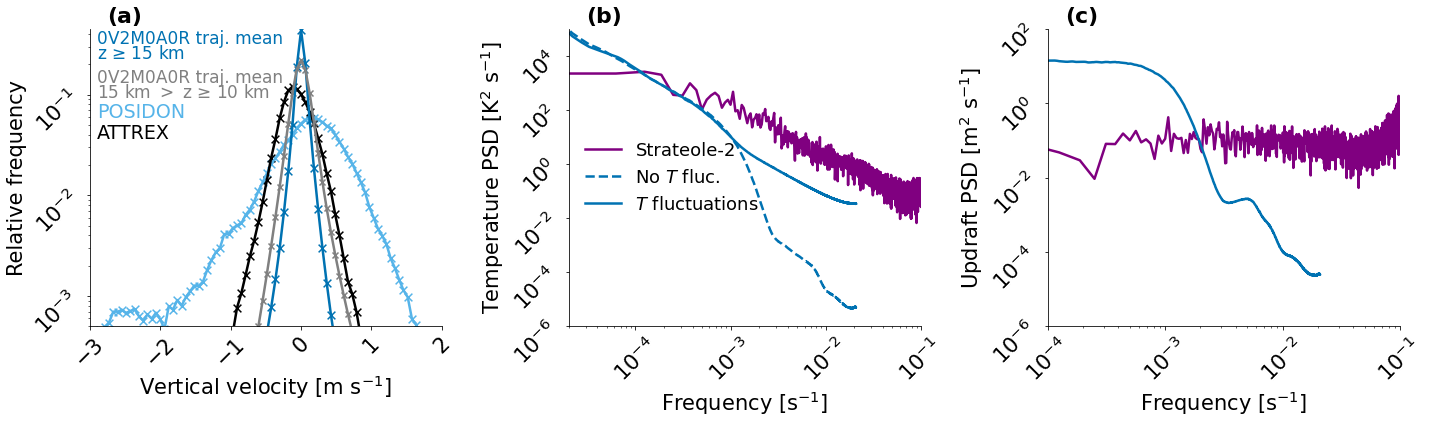

In [66]:
fs = 21
lw = 2.5
ms = 60

fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(20,6))
ax[0].plot((bin_edges[1:] + bin_edges[:-1])/2., h_POSIDON, color=farbe['POSIDON'], lw=lw) # label='POSIDON'
ax[0].plot((bin_edges[1:] + bin_edges[:-1])/2., h_ATTREX, color=farbe['ATTREX'], lw=lw) # label='ATTREX'
ax[0].scatter((bin_edges[1:] + bin_edges[:-1])/2., h_POSIDON, s=ms, marker='x', color=farbe['POSIDON'])
ax[0].scatter((bin_edges[1:] + bin_edges[:-1])/2., h_ATTREX, s=ms, marker='x', color=farbe['ATTREX'])

ax[0].plot((bin_edges[1:] + bin_edges[:-1])/2., np.nanmean(h_0V2M0A0R,axis=0), lw=lw, color=farbe['0V2M0A0R']) # label='Traj. mean'
ax[0].plot((bin_edges[1:] + bin_edges[:-1])/2., np.nanmean(h_0V2M0A0R_1015km,axis=0), lw=lw, color='grey')
ax[0].scatter((bin_edges[1:] + bin_edges[:-1])/2., np.nanmean(h_0V2M0A0R,axis=0), s=ms, marker='x', color=farbe['0V2M0A0R'])
ax[0].scatter((bin_edges[1:] + bin_edges[:-1])/2., np.nanmean(h_0V2M0A0R_1015km,axis=0), marker='x', color='grey')

ax[0].text(0.05,1.02,'(a)', weight='bold', fontsize=fs+1, color='k', transform=ax[0].transAxes)
ax[0].text(0.02,0.95, '0V2M0A0R traj. mean', fontsize=fs-4, color=farbe['0V2M0A0R'], transform=ax[0].transAxes)
ax[0].text(0.02,0.90, 'z $≥$ 15 km', fontsize=fs-4, color=farbe['0V2M0A0R'], transform=ax[0].transAxes)
ax[0].text(0.02,0.82, r'0V2M0A0R traj. mean', fontsize=fs-4, color='grey', transform=ax[0].transAxes)
ax[0].text(0.02,0.77, '15 km $>$ z $≥$ 10 km', fontsize=fs-4, color='grey', transform=ax[0].transAxes)
ax[0].text(0.02,0.7, 'POSIDON', fontsize=fs-2, color=farbe['POSIDON'], transform=ax[0].transAxes)
ax[0].text(0.02,0.63, 'ATTREX', fontsize=fs-2, color=farbe['ATTREX'], transform=ax[0].transAxes)

ax[0].set_yscale('log')
ax[0].spines['right'].set_color('none')
ax[0].set_ylim([0.0005, 0.45])
ax[0].set_xlim([-3, 2])
ax[0].set_xlabel(r'Vertical velocity [m s$^{-1}$]',fontsize=fs)
ax[0].set_ylabel('Relative frequency',fontsize=fs)
sexy_axes(ax[0], fs)

ax[1].plot(freq, T_PSD_Strateole, color='purple', lw=lw, label='Strateole-2')
ax[2].plot(freq, w_PSD_Strateole, color='purple', lw=lw, label='Strateole-2')
ax[1].text(0.05,1.02,'(b)',weight='bold',fontsize=fs+1,color='k',transform=ax[1].transAxes)
ax[2].text(0.05,1.02,'(c)',weight='bold',fontsize=fs+1,color='k',transform=ax[2].transAxes)

ax[1].plot(np.nanmean(T_ff_0V2M0A0R,axis=0), np.nanmean(T_Pxx_0V2M0A0R,axis=0), ls='--', label=r'No $T$ fluc.', lw=lw, color=farbe['0V2M0A0R'])
ax[1].plot(np.nanmean(T_ff_0V2M0A0R_Tf,axis=0), np.nanmean(T_Pxx_0V2M0A0R_Tf,axis=0), label=r'$T$ fluctuations', lw=lw, color=farbe['0V2M0A0R'])
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlim([2*10**-5, 0.1])
ax[1].set_ylim([10**-6, 10**5])
ax[1].legend(loc='center left', frameon=False, fontsize=fs-3)
ax[1].set_ylabel(r'Temperature PSD [K$^2$ s$^{-1}$]',fontsize=fs)
ax[1].set_xlabel(r'Frequency [s$^{-1}$]',fontsize=fs)
sexy_axes(ax[1], fs)

#for j in np.arange(30):
#    ax[2].plot(w_ff_0V2M0A0R[j], w_Pxx_0V2M0A0R[j], color=colors[j], alpha=0.35)
ax[2].plot(np.nanmean(w_ff_0V2M0A0R,axis=0), np.nanmean(w_Pxx_0V2M0A0R,axis=0), linewidth=lw, color=farbe['0V2M0A0R'])
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlim([10**-4, 0.1])
ax[2].set_ylim([10**(-6), 10**2])
ax[2].set_ylabel(r'Updraft PSD [m$^2$ s$^{-1}$]',fontsize=fs)
ax[2].set_xlabel(r'Frequency [s$^{-1}$]',fontsize=fs)
sexy_axes(ax[2], fs)

plt.tight_layout()
#fig.savefig( bd + 'output/traj_dynamics.pdf',bbox_inches='tight' )
plt.show()

# Figure 3: Temperature and specific humidity profile comparisons

In [3]:
# Which set of trajectory statistics do you want to open?

tag = '_E'  # E = 'extract', default 500 synthetic trajectories
#tag = '_2E' # Second (or third) set of 500 synthetic trajectories to test reproducibility
#tag = '_C' # C = 'collocate', minimize the Euclidean distance between sim and obs values
#tag = '_P' # P = 'pinpoint', find the closest numerical value to the obs within the sim
#tag = '_full' # Statistics over the full Flight 7 track

bd = '/groups/sylvia/UTLS-profiles/output/'
stats = []
sim_list = ['1M0O','1M1O','1M3O','2M0O','2M1O','2M3O']
for s in sim_list: 
    ds = xr.open_dataset( bd + 'ICON_synthetic_trajs_stats_' + s + tag + '.nc' )
    stats.append( ds )

In [4]:
min_alt = 5000
max_alt = 22000
icon_sz = 50
    
# Time range from Lee et al. 2019 (6:20-6:48 UTC)    
time0 = datetime(2017, 8, 8, 6, 20)
timef = datetime(2017, 8, 8, 6, 48)

# Full Flight 7 statistics
#time0 = datetime(2017, 8, 8, 4, 0)
#timef = datetime(2017, 8, 8, 7, 15)

In [5]:
# Suppress warnings about levels where there are no data
warnings.filterwarnings("ignore", message="All-NaN slice encountered")
warnings.filterwarnings("ignore", message="Mean of empty slice")
warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice")

# Read in-situ data
alt1, qv_flash, qv_fish, alt2, qi, alt3, temp, theta, alt4, rhice_flash, rhice_fish = \
    read_flighttrack( time0, timef )

# Bin the in-situ data altitudinally
bins_sims, temp_SC_stats, theta_SC_stats, qv_flash_SC_stats, qv_fish_SC_stats, qi_SC_stats, RHi_SC_stats = \
    bin_flighttrack( min_alt, max_alt, alt1, qv_flash, qv_fish, alt2, qi, alt3, temp, theta, alt4, rhice_flash, \
                    rhice_fish )

/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


Text(0.03, 0.93, 'd')

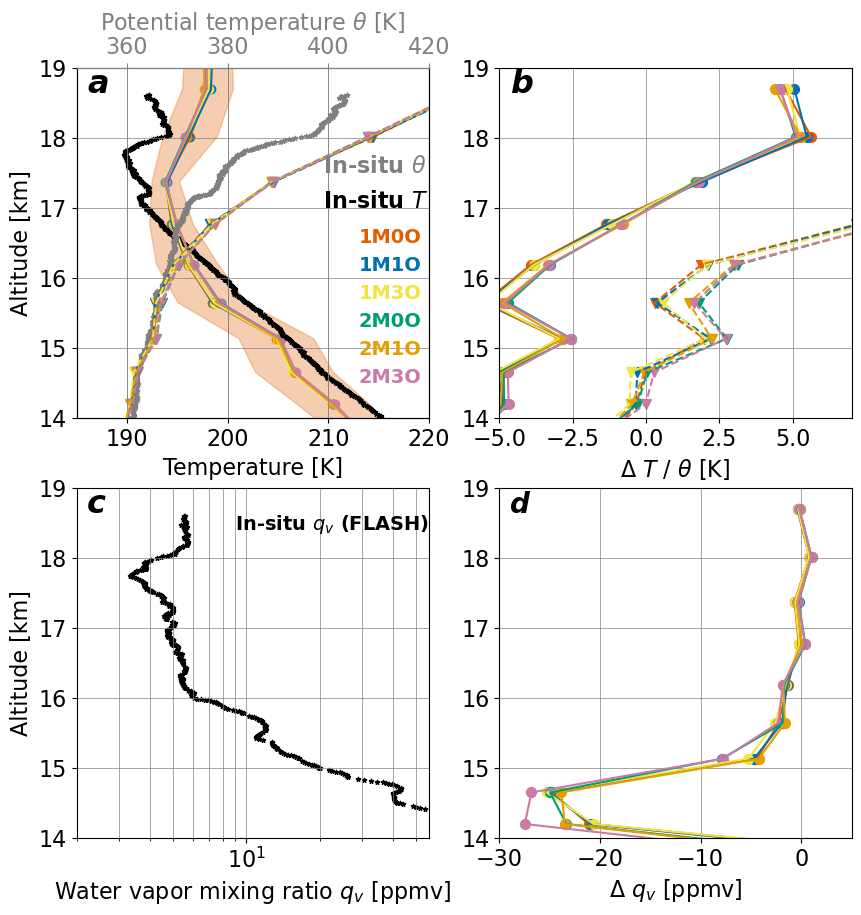

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax0 = ax[0,0].twiny()
axs = list(ax.flatten())
axs.append( ax0 )

# Other plotting parameters
icon_lw = 1.5
icon_alfa = 1
fs = 16
yval = bins_sims/1000

# Specify whether to compare means (l = 0) or medians (l = 1)
k = 'mean'; l = 0

# Axis limits specified
for a in axs:
    a.set_ylim([14, 19])
    a.grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
    a.tick_params('both',labelsize=fs)
ax[0,1].set_xlim([-5, 7])
ax[1,0].set_xlim([2, 10**1.75])
ax[1,1].set_xlim([-30, 5])

# Align grid lines on PANEL A
ax[0,0].set_xlim([185, 220])
ax0.set_xlim([2*185 - 20, 2*220 - 20])
xticks_ax = [190, 200, 210, 220]
xticks_ax0 = [2*x - 20 for x in xticks_ax]
ax[0,0].set_xticks(xticks_ax)
ax0.set_xticks(xticks_ax0)

# Set matching ticks and gridlines
xticks_ax = [190, 200, 210, 220]
xticks_ax0 = [2*x - 20 for x in xticks_ax] 

# PANEL A: Mean (or median) temperature over all trajectories
tm = np.nanmean( stats[0]['temp_'+k], axis=1 )
tstd = np.nanmean( stats[0]['temp_std'], axis=1 )
# Shade the area for +/- a standard deviation for the first simulation
ax[0,0].fill_betweenx( y=yval, x1=tm-tstd, x2=tm+tstd, alpha=0.3, color=farbe['1M0O'] )
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    tm = np.nanmean( stats[i]['temp_'+k], axis=1 )
    ax[0,0].scatter( tm, yval, color=farbe[sl] )
    ax[0,0].plot( tm, yval, lw=icon_lw, color=farbe[sl] )
ax[0,0].scatter(temp, alt3/1000, color='k', s=10, marker='*')
ax[0,0].set_xlabel('Temperature [K]', fontsize=fs)
ax[0,0].set_ylabel('Altitude [km]',fontsize=fs)
ax[0,0].text(0.03, 0.93, 'a', weight='bold', style='italic', fontsize=fs+7, transform=ax[0,0].transAxes)

# PANEL A: Potential temperature 
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    thetam = np.nanmean( stats[i]['theta_'+k], axis=1 )
    thetastd = np.nanmean( stats[i]['theta_std'], axis=1 )
    ax0.scatter( thetam, yval, marker='v', s=icon_sz, color=farbe[sl] )
    ax0.plot( thetam, yval, lw=icon_lw, ls='--', color=farbe[sl] )
    ax0.text(0.8, 0.5-i*0.08, sl, fontsize=fs-2, weight='bold', color=farbe[sl], transform=ax0.transAxes)
ax0.scatter(theta, alt3/1000, color='gray', s=10, marker='*')
ax0.set_xlabel(r'Potential temperature $\theta$ [K]', fontsize=fs, color='gray')
ax0.spines['top'].set_color('gray')
ax0.tick_params(axis='x',colors='gray')
ax0.text(0.7, 0.7, r'In-situ $\theta$', fontsize=fs, weight='bold', color='gray', transform=ax0.transAxes)
ax0.text(0.7, 0.6, r'In-situ $T$', fontsize=fs, weight='bold', color='black', transform=ax0.transAxes)

# PANEL B: Temperature and theta anomalies
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    tm = np.nanmean( stats[i]['temp_'+k], axis=1 )
    thetam = np.nanmean( stats[i]['theta_'+k], axis=1 )
    ax[0,1].scatter( tm-temp_SC_stats[l], yval, s=icon_sz, alpha=icon_alfa, color=farbe[sl] )
    ax[0,1].plot( tm-temp_SC_stats[l], yval, lw=icon_lw, color=farbe[sl] )
    ax[0,1].scatter( thetam-theta_SC_stats[l], yval, s=icon_sz, marker='v', alpha=icon_alfa, color=farbe[sl] )
    ax[0,1].plot( thetam-theta_SC_stats[l], yval, lw=icon_lw, ls='--', color=farbe[sl] )
ax[0,1].set_xlabel(r'$\Delta$ $T$ / $\theta$ [K]', fontsize=fs)
ax[0,1].text(0.03, 0.93, 'b', weight='bold', style='italic', fontsize=fs+7, transform=ax[0,1].transAxes)

# PANEL C: Mean (or median) specific humidity across all trajectories
qvm = np.nanmean( stats[0]['tot_qv_dia_'+k], axis=1 )
qvstd = np.nanmean( stats[0]['tot_qv_dia_std'], axis=1 )
ax[1,0].fill_betweenx( y=yval, x1=qvm-qvstd, x2=qvm+qvstd, alpha=0.3, color=farbe['1M0O'] )
ax[1,0].scatter( qv_flash, alt1/1000, color='k', s=10, marker='*')
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    qvm = np.nanmean( stats[i]['tot_qv_dia_'+k], axis=1 )
    ax[1,0].scatter( qvm, yval, s=icon_sz, color=farbe[sl] )
    ax[1,0].plot( qvm, yval, lw=icon_lw, color=farbe[sl] )
ax[1,0].text(0.45, 0.88, 'In-situ $q_v$ (FLASH)', fontsize=fs-2, weight='bold', transform=ax[1,0].transAxes)
ax[1,0].set_xlabel('Water vapor mixing ratio $q_v$ [ppmv]',fontsize=fs)
ax[1,0].set_ylabel('Altitude [km]',fontsize=fs)
ax[1,0].set_xscale('log')
ax[1,0].text(0.03, 0.93, 'c', weight='bold', style='italic', fontsize=fs+7, transform=ax[1,0].transAxes)

# PANEL D: Specific humidity anomalies
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    qvm = np.nanmean( stats[i]['qv_'+k], axis=1 )
    ax[1,1].scatter( qvm-qv_flash_SC_stats[l], yval, s=icon_sz, alpha=icon_alfa, color=farbe[sl] )
    ax[1,1].plot( qvm-qv_flash_SC_stats[l], yval, lw=icon_lw, color=farbe[sl])
ax[1,1].set_xlabel(r'$\Delta$ $q_v$ [ppmv]', fontsize=fs)
ax[1,1].text(0.03, 0.93, 'd', weight='bold', style='italic', fontsize=fs+4, transform=ax[1,1].transAxes)

#fig.savefig( 'output/T-qv-profile-comparison' + tag + '.pdf', bbox_inches='tight' )

# Figure 4: Relative humidity and ice mass mixing ratio profile comparisons

In [10]:
sim_list = ['1M0O','1M1O','1M3O','2M0O','2M1O','2M3O']

/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


Text(0.03, 0.93, 'c')

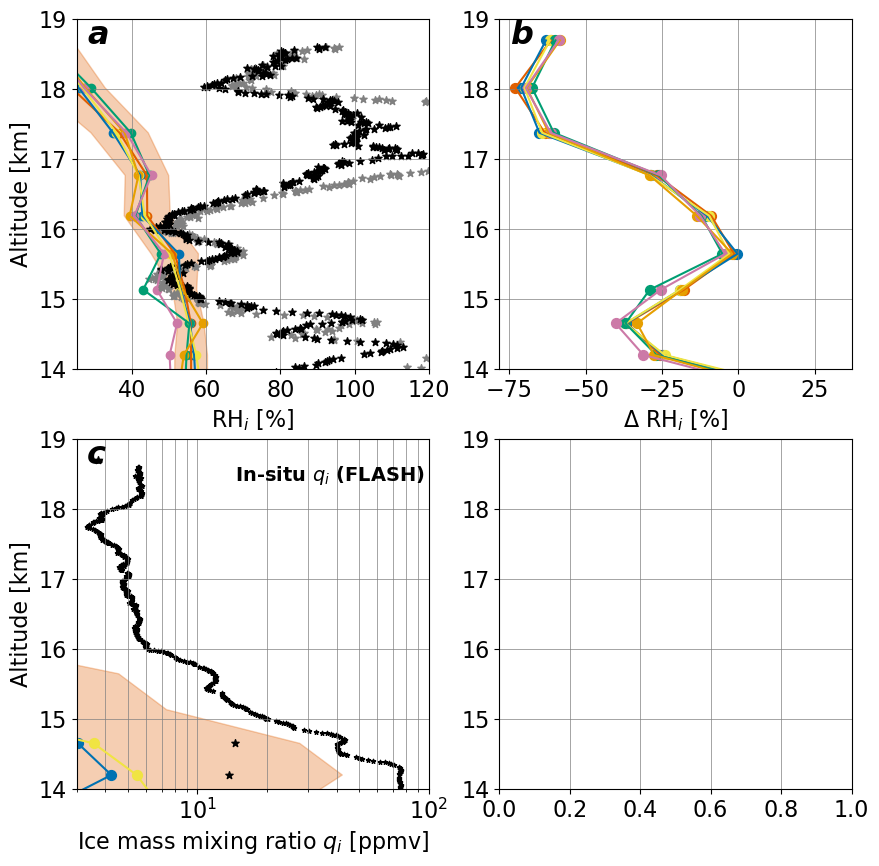

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axs = list(ax.flatten())

# Other plotting parameters
icon_lw = 1.5
icon_alfa = 1
fs = 16
yval = bins_sims/1000

# Specify whether to compare means (l = 0) or medians (l = 1)
k = 'median'; l = 1

# Axis limits specified
for a in axs:
    a.set_ylim([14, 19])
    a.grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
    a.tick_params('both',labelsize=fs)
ax[0,0].set_xlim([25, 120])
ax[1,0].set_xlim([3*10**0, 10**2])
#ax[1,1].set_xlim([-30, 5])

# PANEL A: Mean (or median) RHice over all trajectories
rhim = np.nanmedian( stats[0]['rh_'+k], axis=1 )
rhistd = np.nanmean( stats[0]['rh_std'], axis=1 )
# Shade the area for +/- a standard deviation for the first simulation
ax[0,0].fill_betweenx( y=yval, x1=rhim-rhistd, x2=rhim+rhistd, alpha=0.3, color=farbe['1M0O'] )
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    rhim = np.nanmedian( stats[i]['rh_'+k], axis=1 )
    ax[0,0].scatter( rhim, yval, color=farbe[sl] )
    ax[0,0].plot( rhim, yval, lw=icon_lw, color=farbe[sl] )
ax[0,0].scatter(rhice_fish, alt4/1000, color='gray', s=30, marker='*')
ax[0,0].scatter(rhice_flash, alt4/1000, color='k', s=30, marker='*')
ax[0,0].set_xlabel(r'RH$_i$ [%]', fontsize=fs)
ax[0,0].set_ylabel('Altitude [km]',fontsize=fs)
ax[0,0].text(0.03, 0.93, 'a', weight='bold', style='italic', fontsize=fs+7, transform=ax[0,0].transAxes)

# PANEL B: RHi anomalies
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    rhim = np.nanmean( stats[i]['rh_'+k], axis=1 )
    ax[0,1].scatter( rhim-RHi_SC_stats[l], yval, s=icon_sz, alpha=icon_alfa, color=farbe[sl] )
    ax[0,1].plot( rhim-RHi_SC_stats[l], yval, lw=icon_lw, color=farbe[sl] )
ax[0,1].set_xlabel(r'$\Delta$ RH$_i$ [%]', fontsize=fs)
ax[0,1].text(0.03, 0.93, 'b', weight='bold', style='italic', fontsize=fs+7, transform=ax[0,1].transAxes)

# PANEL C: Mean (or median) qi over all trajectories
qim = np.nanmedian( stats[0]['qi_'+k], axis=1 )
qistd = np.nanmean( stats[0]['qi_std'], axis=1 )
ax[1,0].fill_betweenx( y=yval, x1=qim-qistd, x2=qim+qistd, alpha=0.3, color=farbe['1M0O'] )
ax[1,0].scatter( qv_flash, alt1/1000, color='k', s=10, marker='*')
for i, sl in zip(np.arange(len(sim_list)), sim_list):
    qim = np.nanmedian( stats[i]['qi_'+k], axis=1 )
    ax[1,0].scatter( qim, yval, s=icon_sz, color=farbe[sl] )
    ax[1,0].plot( qim, yval, lw=icon_lw, color=farbe[sl] )
ax[1,0].scatter(qi_SC_stats[0], bins_sims/1000, color='k', s=30, marker='*')
ax[1,0].text(0.45, 0.88, 'In-situ $q_i$ (FLASH)', fontsize=fs-2, weight='bold', transform=ax[1,0].transAxes)
ax[1,0].set_xlabel(r'Ice mass mixing ratio $q_i$ [ppmv]', fontsize=fs)
ax[1,0].set_ylabel('Altitude [km]',fontsize=fs)
ax[1,0].set_xscale('log')
ax[1,0].text(0.03, 0.93, 'c', weight='bold', style='italic', fontsize=fs+7, transform=ax[1,0].transAxes)


/home/u18/sylvia/.conda/envs/ncplot/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN

Text(0.03, 0.93, '(d)')

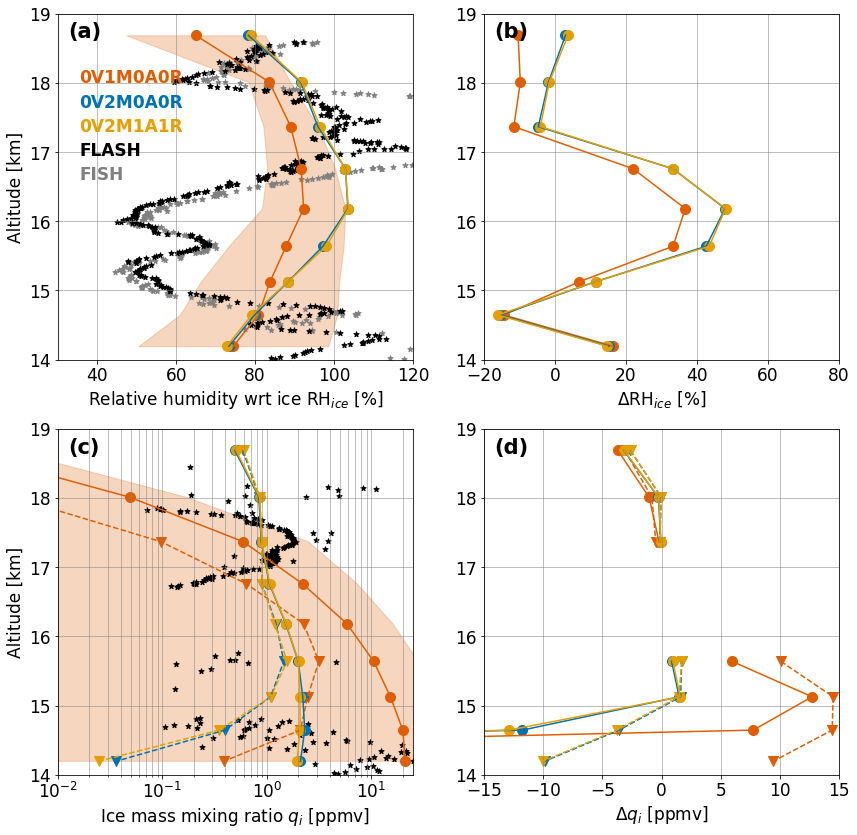

In [7]:
if tag == '_pinpoint':
    y1 = 14
    ax[0,1].set_xlim([-20, 20])
    ax[1,1].set_xlim([-5, 5])
    ax[0,0].set_xlim([30, 120])
    ax[1,0].set_xlim([0.01, 25])
elif tag != '_full':
    y1 = 14
    ax[0,1].set_xlim([-20, 80])
    ax[1,1].set_xlim([-15, 15])
    ax[0,0].set_xlim([30, 120])
    ax[1,0].set_xlim([0.01, 25])
else:
    ax[0,0].set_xlim([25, 120])
    ax[1,1].set_xlim([-100, 10])
    ax[1,0].set_xlim([10**(-6), 10**3])




# We don't use k below because we are showing both the mean and median always.
for s_indx, s_name in enumerate( sim_list ):
    ax[1,0].scatter(np.nanmean(sim_stats[s_indx,3,0],axis=1), bins_sims/1000, color=farbe[s_name], s=icon_sz)
    ax[1,0].plot(np.nanmean(sim_stats[s_indx,3,0],axis=1), bins_sims/1000, color=farbe[s_name], lw=icon_lw)
    ax[1,0].scatter(np.nanmedian(sim_stats[s_indx,3,1],axis=1), bins_sims/1000, marker='v', color=farbe[s_name], s=icon_sz)
    ax[1,0].plot(np.nanmedian(sim_stats[s_indx,3,1],axis=1), bins_sims/1000, ls='--', color=farbe[s_name], lw=icon_lw)
ax[1,0].set_ylim([y1, y2])
ax[1,0].set_xscale('log')
#ax[1,0].set_xlim([10**(-3),10**2])
ax[1,0].set_xlabel(r'Ice mass mixing ratio $q_i$ [ppmv]', fontsize=fs)
ax[1,0].tick_params('both',labelsize=fs)
ax[1,0].text(0.03, 0.93, '(c)', weight='bold', fontsize=fs+4, transform=ax[1,0].transAxes)
ax[1,0].set_ylabel('Altitude [km]', fontsize=fs)

ax[1,1].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
for s_indx, s_name in enumerate( sim_list ):
    ax[1,1].scatter(np.nanmean(sim_stats[s_indx,3,k,:,:20],axis=1) - qi_SC_stats[0], bins_sims/1000, color=farbe[s_name], s=icon_sz)
    ax[1,1].plot(np.nanmean(sim_stats[s_indx,3,k,:,:20],axis=1) - qi_SC_stats[0], bins_sims/1000, color=farbe[s_name], lw=icon_lw)
    ax[1,1].scatter(np.nanmedian(sim_stats[s_indx,3,0],axis=1) - qi_SC_stats[1], bins_sims/1000, marker='v', color=farbe[s_name], s=icon_sz)
    ax[1,1].plot(np.nanmedian(sim_stats[s_indx,3,0],axis=1) - qi_SC_stats[1], bins_sims/1000, ls='--', color=farbe[s_name], lw=icon_lw)
ax[1,1].set_ylim([y1, y2])
#ax[1,1].set_xscale('log')
ax[1,1].set_xlabel(r'$\Delta q_i$ [ppmv]', fontsize=fs)
ax[1,1].tick_params('both',labelsize=fs)
ax[1,1].text(0.03, 0.93, '(d)', weight='bold', fontsize=fs+4, transform=ax[1,1].transAxes)

#fig.savefig('output/RHi-qi-comp' + tag + '.pdf')

# Scraps - Calculating PSDs from flight track data (not to be compared to Lagrangian trajectories)

In [ ]:
# Fixed set of frequencies
n = 8000
freq = np.linspace(0,0.4999,n)

# Number of POSIDON flights (9)
posidon_dates = posidon_winds['date'].unique()

# Calculate the power spectral density of observational temperature and updraft signals.
T_PSD_POSIDON = np.zeros((len(posidon_dates), n))
w_PSD_POSIDON = np.zeros((len(posidon_dates), n))

for j, date in enumerate(posidon_dates):
    subset = posidon_winds[(posidon_winds['date'] == date)] 
    
    # Generate an instance of Class traj_psd with temp = input T time series
    # The T time series have lengths of 11176, 10480, 11190, 16964, 16208, 15551, 9612, 15899, 10114
    traj_obj = traj_psd(subset['T'].values)
    traj_obj2 = traj_psd(subset['w'].values)
    
    # Calculate the power spectral density
    ff, Pxx, _ = traj_obj.calc_psd()
    ff2, Pxx2, _ = traj_obj2.calc_psd()
    
    # Interpolate the PSD to a fixed set of frequencies
    f = interpolate.interp1d(ff, Pxx, kind='cubic')
    f2 = interpolate.interp1d(ff2, Pxx2, kind='cubic')
    
    # Append the values to the multidimensional list
    T_PSD_POSIDON[j] = f(freq)
    w_PSD_POSIDON[j] = f2(freq)

In [ ]:
# Number of ATTREX flights (6)
attrex_dates = attrex_winds['date'].unique()

# Calculate the power spectral density of observational temperature signals.
T_PSD_ATTREX = np.zeros((len(attrex_dates), n))
w_PSD_ATTREX = np.zeros((len(attrex_dates), n))

for j, date in enumerate(attrex_dates):
    subset = attrex_winds[(attrex_winds['date'] == date)] 
    
    # Generate an instance of Class traj_psd with temp = input T time series
    # The T time series have lengths of 39731, 37179, 32700, 46743, 50830, 36647
    traj_obj = traj_psd(subset['T'].values)
    traj_obj2 = traj_psd(subset['w'].values)
    
    # Calculate the power spectral density
    ff, Pxx, _ = traj_obj.calc_psd()
    ff2, Pxx2, _ = traj_obj2.calc_psd()

    # Interpolate the PSD to a fixed set of frequencies
    f = interpolate.interp1d(ff, Pxx, kind='cubic')
    f2 = interpolate.interp1d(ff2, Pxx2, kind='cubic')
    
    # Append the values to the multidimensional list
    T_PSD_ATTREX[j] = f(freq)
    w_PSD_ATTREX[j] = f2(freq)